# Model Predictive Control

An entire marathon! Trying to make model predictive control (slightly more advanced than LQG) work. Main reference: https://ieeexplore-ieee-org.libproxy.berkeley.edu/stamp/stamp.jsp?tp=&arnumber=8511551

Steps:

1. Keck mirror finite-element analysis: find its $\omega_D, \omega_T, d$. Will just skip over this. 
2. Convert TF to SS and augment to make $C_i, B_i$.
3. Augment with turbulence and vibrations to make $A_i$ and $C_0$.
4. Pick $R_y, R_u, u_{max}$.
5. Solve the quadratic system!

This is possibly the worst structured code I've ever written, sorry!

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal, io, linalg
from cvxopt import solvers, matrix

from aberrations import *
from observer import *
from controller import *
from fractal_deriv import design_filt
from utils import *

f_sampling = 1000
rms = lambda data: np.sqrt(np.mean(data ** 2))
eps = 1e-8

In [2]:
# step 1: Keck mirror FEA results.

# These are completely random numbers. 

w_TT = 100
z_TT = 1

def make_impulse(w, z, T=np.arange(0, 1, 0.001)):
    num = [w**2]
    den = [1, 2 * w * z, w**2]
    tf = signal.TransferFunction(num, den)
    impulse = signal.impulse(tf, T=T)
    return impulse[0], impulse[1] / sum(impulse[1])

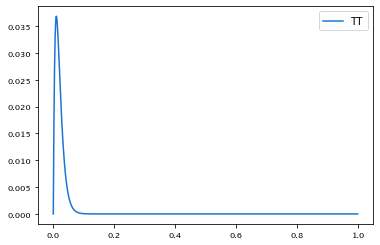

In [3]:
#plt.plot(*make_impulse(w_DM, z_DM), label="DM")
plt.plot(*make_impulse(w_TT, z_TT), label="TT")
plt.legend() 

In [4]:
num, den = signal.cont2discrete(([w_TT ** 2], [1, 2 * w_TT * z_TT, w_TT ** 2]), dt=1/f_sampling)[:2]
A_TT, B_TT, C_TT, D_TT = signal.tf2ss(num, den)

/usr/local/lib/python3.7/site-packages/scipy/signal/filter_design.py:1619: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


In [5]:
A_TT, B_TT, C_TT, D_TT

(array([[ 1.80967484, -0.81873075],
        [ 1.        ,  0.        ]]), array([[1.],
        [0.]]), array([[0.00467884, 0.00437708]]), array([[0.]]))

In [6]:
Q_TT = 1e-4 * np.array([[1, 0], [0, 0]]) # mas^2, arbitrary

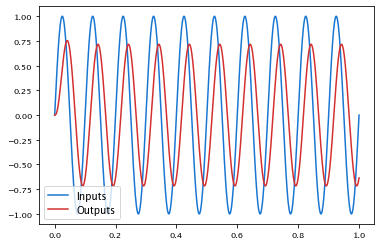

In [7]:
# I'm skeptical of this model of the TTM. Let's drive it with a sine wave and see what happens.

size = 1000
times = np.linspace(0, 1, size)
U = np.sin(2 * np.pi * 10 * times)
Y = np.zeros(size,)
state = np.array([0, 0])
for i, u in enumerate(U):
    state = A_TT.dot(state) + B_TT.dot(u).flatten() # I hate numpy's row vector handling
    Y[i] = C_TT.dot(state) + D_TT.dot(u)
    
plt.plot(times, U, label='Inputs')
plt.plot(times, Y, label='Outputs')
plt.legend()

Alright, seems reasonable!

Took 9 iterations to get steady-state covariance.
Took 0 iterations to get steady-state covariance.


/Users/adityasengupta/projects/adaptive-optics/control/dev/observer.py:172: RuntimeWarning: invalid value encountered in sqrt
  return A * np.exp(-k * 2 * np.pi * f * times) * np.cos(2 * np.pi * f * np.sqrt(1 - k**2) * times - p)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


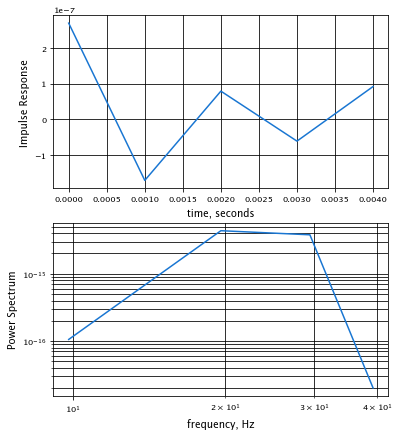

In [56]:
# now, let's import the usual Kalman filter! at first, no vibrations.

# pol = np.load('../telemetry/sim_openloops_0.npy')
pol = get_keck_tts()[1][:,0]
kfilter_turb = make_kfilter_turb(make_impulse_from_tt(pol[:100], N=5))
kfilter_vibe = make_kfilter_vibe(*vibe_fit_freq(get_psd(pol[:100]), N=2))

In [57]:
kfilter_TT = KFilter(np.zeros(2,), A_TT, B_TT.flatten(), Q_TT, C_TT, np.array([eps]), has_input=True)
# the Q and R don't matter because I'm setting the Kalman gain to zero
kfilter_TT.K *= 0

Took 8 iterations to get steady-state covariance.


In [58]:
state_WFS = np.array([0, 0])
A_WFS = np.array([[0, 0], [1, 0]])
B_WFS = np.array([1, 0]) # takes in residual at timestep k
H_WFS = np.array([[0, 1]])
Q_WFS = np.identity(2) 
R_WFS = np.array([eps])
# the Q and R don't matter because I'm setting the Kalman gain to zero

kfilter_WFS = KFilter(state_WFS, A_WFS, B_WFS, Q_WFS, H_WFS, R_WFS, has_input=True)
kfilter_WFS.K *= 0

Took 1 iterations to get steady-state covariance.


In [60]:
kfilter = kfilter_WFS + kfilter_turb + kfilter_vibe + kfilter_TT
kfilter.H = np.array([[0, 1, 1, 0]]).dot(kfilter.H)

In [61]:
N_WFS = 2 # two frame delay
N_turb = kfilter_turb.state.size
N_vibe = kfilter_vibe.state.size
N_CM = 2 # second order control loop model
N_state = N_WFS + N_turb + N_vibe + N_CM
N_frames = 12 #arbitrary
B_temp = B_WFS.reshape((B_WFS.size,1))
temp1 = B_temp.dot(kfilter_turb.H)
temp2 = -B_temp.dot(C_TT)

In [62]:
# hardcoding because some things are just plain weird
kfilter.B = np.array(([0] * (N_WFS + N_turb + N_vibe)) + list(B_TT.flatten()))

In [63]:
for i, j in [(0, 2), (0, 3), (1, 2), (1, 3)]: # works with a hardcoded N_WFS = 2
    kfilter.A[i][j] = temp1[i][j-2]
    kfilter.A[i][j+2] = temp2[i][j-2]

In [64]:
# at this point, the filter should be set up properly
kfilter.state = np.zeros(kfilter.A.shape[0],)

def run(kfilter, *args, save_physics=False):
    if not hasattr(kfilter, "B"):
        measurements = args
        inputs = measurements
    else:
        measurements, inputs = args
    steps = len(measurements)
    pos_r = np.zeros(steps)
    if save_physics:
        predictions = np.zeros(steps)

    for k in range(steps):
        kfilter.update(measurements[k])
        pos_r[k] = kfilter.measure()
        kfilter.predict(pos_r[k])
        if save_physics:
            predictions[k] = kfilter.measure() # off by one?
    if save_physics:
        return pos_r, predictions
    return pos_r

res, phy = run(kfilter, pol, np.zeros(pol.size,), save_physics=True)

In [65]:
R_y = np.identity(N_frames)
R_u = np.identity(N_frames) * 100
C_0 = np.vstack([kfilter.H.dot(kfilter.A ** i) for i in range(N_frames)])
D_0 = np.zeros((N_frames,N_frames))
for i in range(N_frames):
    for j in range(i):
        D_0[i][j] = kfilter.H.dot(kfilter.A ** (i - j - 1)).dot(kfilter.B)

In [73]:
kfilter.state = np.zeros(kfilter.A.shape[0],)
H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
H3 = D_0.dot(R_y).dot(D_0.T) + R_u
u_max = float(max(np.diff(pol[:100]))) # arbitrary
G = np.identity(N_frames)
h = np.vstack([u_max] * N_frames)

In [74]:
solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='qpOASES')['x']

In [75]:
np.array(solution) # should be zero or almost zero, because the state's zero

array([[2.34583673e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11],
       [1.93402806e-11]])

In [76]:
kfilter.state = np.zeros(kfilter.A.shape[0],)

shifts = np.diff(pol)
res = np.zeros(pol.shape)
res[0] = pol[0]
actions = np.zeros(pol.shape)
for i in range(1, pol.size):
    try:
        res[i] = res[i - 1] + shifts[i - 1] + actions[i - 1]
        measurement = res[i] + np.random.normal(0, 0.06)
        kfilter.update(measurement)
        if i < pol.size - N_frames + 1 and i % N_frames == 0:
            H2 = 2 * kfilter.state.T.dot(C_0.T.dot(R_y).dot(D_0))
            solvers.options['show_progress'] = False
            solution = solvers.qp(matrix(H3), matrix(H2), matrix(G), matrix(h, tc='d'), solver='qpOASES')
            for j in range(i, i + N_frames):
                actions[j] = solution['x'][j - i]

        kfilter.predict(actions[i])
        
    except:
        print(i)
        raise

In [77]:
rms(pol)

0.15740646

In [78]:
rms(res)

0.259323225656821

In [72]:
max(actions)

0.02279136299857678

(1e-10, 0.9757077957014229)

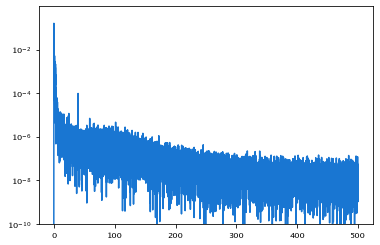

In [50]:
plt.semilogy(*signal.periodogram(pol, fs=f_sampling))
plt.ylim(1e-10)

(1e-10, 0.04055203997400555)

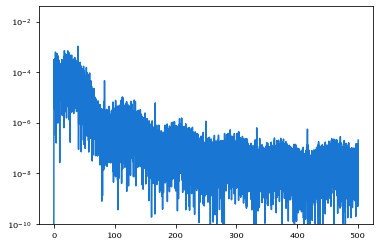

In [51]:
plt.semilogy(*signal.periodogram(res, fs=f_sampling))
plt.ylim(1e-10)